In [1]:
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import collections

from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

from keras.utils.np_utils import to_categorical
from keras.utils import plot_model

from sklearn import model_selection
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# Load data

In [2]:
df = pd.read_csv('data/cleanData.csv')
df['sentiment'] = np.where(df['Label']==1, 1, 0)
df

,Text,Label,sentiment
0,modi promise,-1,0
1,say vote modi welcome bjp told rahul main camp...,1,1
2,ask supporter prefix chowkidar name modi great...,1,1
3,answer among powerful world leader today trump...,1,1
4,upcoming election india saga go important pair...,1,1
...,...,...,...
34418,modi know sell institution like idbi bank form...,-1,0
34419,saw video full comedy show disclose plan test ...,-1,0
34420,dont waste think capacity observation people modi,-1,0
34421,open possibility shell company set sole purpos...,-1,0


In [3]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 20 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 100
GLOVE_DIR = "E:/Glove/glove.6B.100d.txt"

In [4]:
y = df['sentiment']
text = list(df['Text'].astype(str))

# Tokenizer configured to only take into account the MAX_NB_WORDS most common words

In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)

sequences = tokenizer.texts_to_sequences(text)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))
max_vocab_words = len(word_index)

Vocabulary size: 36882


In [6]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', data.shape)
print('Shape of sentiment tensor:', y.shape)

Shape of data tensor: (34423, 20)
Shape of sentiment tensor: (34423,)


# Train test split

In [7]:
x_train, x_val, y_train, y_val = model_selection.train_test_split(data,y,test_size=0.2)

print('Size of Training data  : ', x_train.shape[0])
print('Size of Validation data: ', x_val.shape[0])

Train_counts = pd.DataFrame(y_train.values, columns = list('a'))
print('\nTrain Data Distribution')
print(Train_counts['a'].value_counts())

Test_counts = pd.DataFrame(y_val.values, columns = list('a'))
print('\n\nValidation Data Distribution')
print(Test_counts['a'].value_counts())

Size of Training data  :  27538
Size of Validation data:  6885

Train Data Distribution
1    14312
0    13226
Name: a, dtype: int64


Validation Data Distribution
1    3631
0    3254
Name: a, dtype: int64


In [10]:
# Sample data
# sample data
print('Tokenized sentences: \n', data[10])
print('sentiment: \n', y[10])

Tokenized sentences: 
 [ 233   94    1  928 1909 1886    5   36   81  900   36  272  140 2687
  346  742 6603  346   32   20]
sentiment: 
 1


# Create model

In [11]:
%%time

embeddings_index = {}
f = open(GLOVE_DIR, encoding='utf-8')
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: E:/Glove/glove.6B.100d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!
Wall time: 11.4 s


In [16]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)

x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = Dropout(0.1)(x)
x = Dense(50, activation="tanh")(x)
x = Dropout(0.1)(x)
preds = Dense(1, activation="sigmoid")(x)

In [18]:
model = Model(sequence_input, preds)
model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = ['accuracy'])
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
embeddings (Embedding)       (None, 20, 100)           3688300   
_________________________________________________________________
lstm_layer (LSTM)            (None, 20, 60)            38640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 60)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 20, 50)            3050      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 50)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 20, 1)            

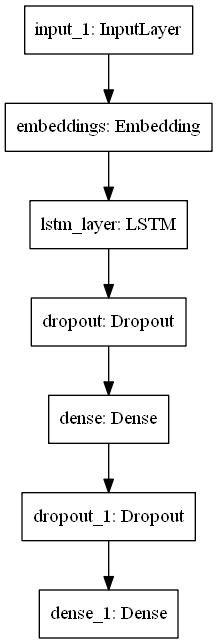

In [14]:
# model architecture
plot_model(model)

# Training

Training progress:
Epoch 1/3
861/861 [==============================] - 7s 8ms/step - loss: 0.6112 - accuracy: 0.6477 - val_loss: 0.5596 - val_accuracy: 0.6911
Epoch 2/3
861/861 [==============================] - 7s 8ms/step - loss: 0.5441 - accuracy: 0.7048 - val_loss: 0.5376 - val_accuracy: 0.7087
Epoch 3/3
861/861 [==============================] - 7s 8ms/step - loss: 0.5145 - accuracy: 0.7254 - val_loss: 0.5116 - val_accuracy: 0.7284
Wall time: 22.4 s


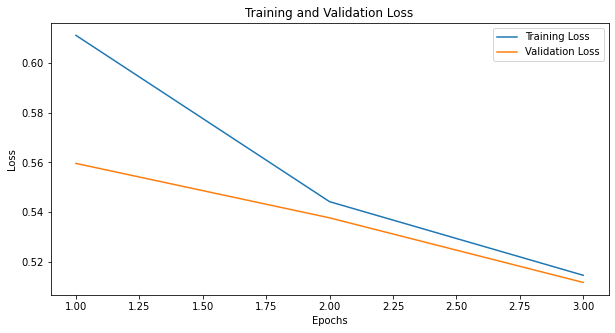

In [19]:
%%time
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 3, batch_size=32, validation_data=(x_val, y_val))

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']


fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(epochs, loss, label='Training Loss')
ax.plot(epochs, val_loss, label='Validation Loss')
ax.set_title('Training and Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()

In [33]:
predicted = model.predict(x_val)
pred = []
for i in range(len(predicted)):
    mean = sum(predicted[i])/len(predicted[i])
    if mean < 0.5:
        pred.append(0)
    else:
        pred.append(1)

Confusion_Matrix 
 [[2456  798]
 [ 750 2881]]
Accuracy: 77.52%


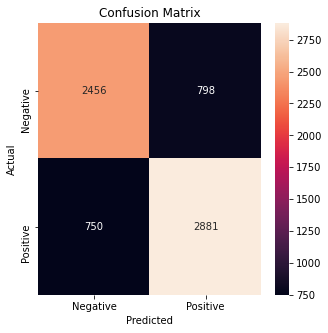

In [38]:
conf_mat = confusion_matrix(y_val, pred)
print('Confusion_Matrix', '\n', conf_mat)

fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

acc = (conf_mat[0][0]+conf_mat[1][1])/x_val.shape[0]
print('Accuracy: {:.2f}%'.format(acc*100))